In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import datetime


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-17 23:09:24.849699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import os
import shutil
import random
from collections import defaultdict

# Chemin vers le répertoire principal contenant les classes
main_directory = './data/plant_village/segmented/'

# Chemin vers le répertoire de train et de test
train_directory = './data/plant_village/segmented_train/'
test_directory = './data/plant_village/segmented_test/'

# Création des répertoires de train et de test s'ils n'existent pas déjà
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Pourcentage de données pour l'ensemble de test
test_split = 0.2  # 20% pour l'ensemble de test

# Dictionnaire pour stocker les fichiers par classe
class_files = defaultdict(list)

# Parcourir chaque classe dans le répertoire principal
for class_folder in os.listdir(main_directory):
    class_path = os.path.join(main_directory, class_folder)
    
    # Vérifier si l'élément parcouru est un répertoire et exclure les répertoires spéciaux
    if not os.path.isdir(class_path) or class_folder.startswith('.'):
        continue
    
    # Liste des fichiers/images dans la classe
    files = os.listdir(class_path)
    
    # Filtrer les fichiers pour exclure le répertoire .ipynb_checkpoints
    files = [file for file in files if not file.startswith('.')]
    
    # Stocker les fichiers de chaque classe dans le dictionnaire
    class_files[class_folder] = files

# Répartition des données pour chaque classe entre train et test
for class_folder, files in class_files.items():
    random.shuffle(files)
    test_size = int(len(files) * test_split)
    test_files = files[:test_size]
    train_files = files[test_size:]
    
    # Répertoires de train et de test pour chaque classe
    train_class_dir = os.path.join(train_directory, class_folder)
    test_class_dir = os.path.join(test_directory, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Copie des fichiers dans les répertoires de train et de test
    for file in test_files:
        src = os.path.join(main_directory, class_folder, file)
        dst = os.path.join(test_class_dir, file)
        shutil.copy(src, dst)
    
    for file in train_files:
        src = os.path.join(main_directory, class_folder, file)
        dst = os.path.join(train_class_dir, file)
        shutil.copy(src, dst)

In [5]:
BASE_DIR = './data/plant_village/segmented/'
TRAIN_DIR = os.path.join('./data/plant_village/', "segmented_train")
TEST_DIR = os.path.join('./data/plant_village/', "segmented_test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64
print(TRAIN_DIR)

./data/plant_village/segmented_train


In [6]:
tf.__version__

'2.12.0'

In [7]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

In [8]:
EPOCHS = 30
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

In [9]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count

print(f'\nTotal validation images: {total_train}')


Total validation images: 43457


In [10]:
total_test = 0

for d in os.listdir(TEST_DIR):
    if not d.startswith('.'): 
        path = os.path.join(TEST_DIR, d)
        img_count = len(os.listdir(path))
        total_test += img_count

print(f'\nTotal validation images: {total_test}')


Total validation images: 10849


In [11]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 43457 images belonging to 38 classes.


In [12]:
test_image_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=TEST_DIR,
    shuffle=True,
    target_size=IMG_SHAPE,
)

Found 10849 images belonging to 38 classes.


In [13]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


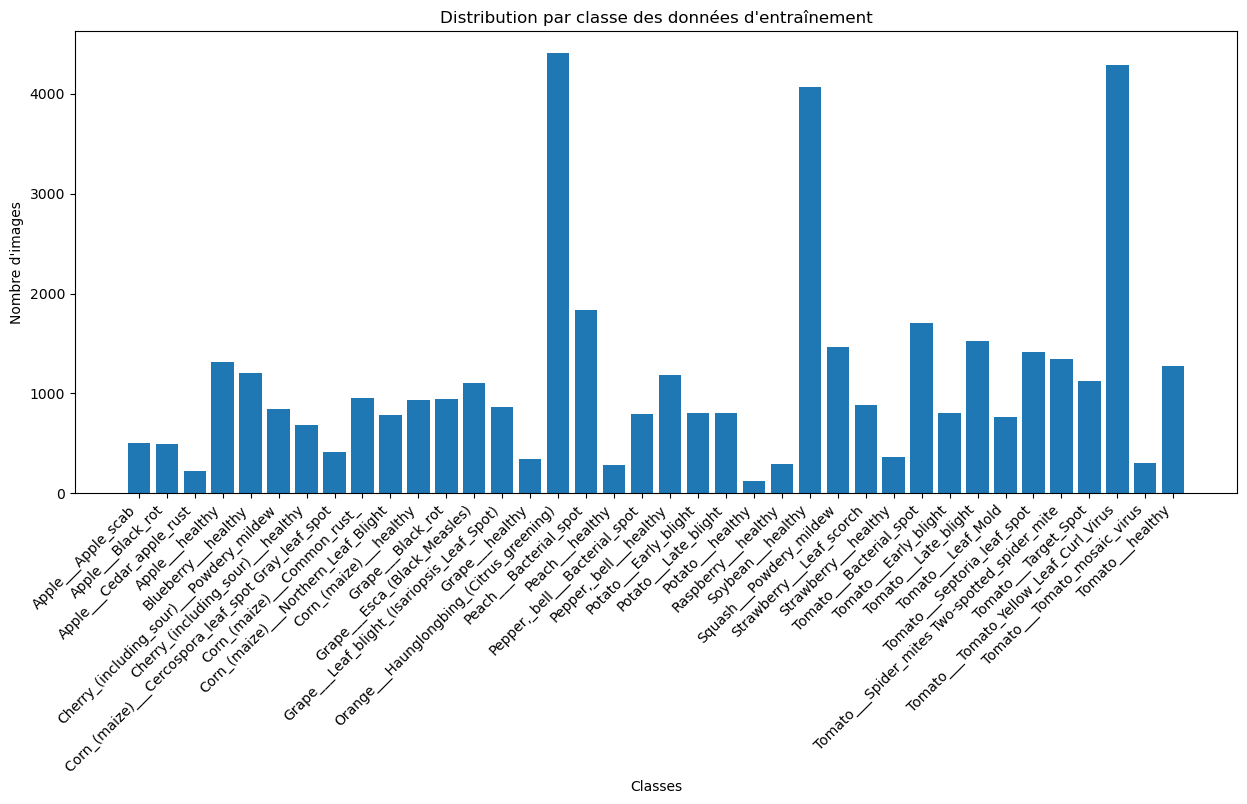

In [14]:
class_counts = train_data_gen.labels
unique, counts = np.unique(class_counts, return_counts=True)

class_names = list(train_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
plt.bar(class_names, counts)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution par classe des données d\'entraînement')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Blueberry___healthy
 5 : Cherry_(including_sour)___Powdery_mildew
 6 : Cherry_(including_sour)___healthy
 7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 8 : Corn_(maize)___Common_rust_
 9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_blight
31 : Tomato___Leaf_Mold
32 : Tomato___Septoria_leaf_spot
33 

In [ ]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu")(inputs)
conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu")(depth_conv_1)
max_pool_1 = MaxPooling2D()(conv_1)

depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_1)
conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu")(depth_conv_2)
max_pool_2 = MaxPooling2D()(conv_2)

depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_2)
conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu")(depth_conv_3)
max_pool_3 = MaxPooling2D()(conv_3)

depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_3)
conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu")(depth_conv_4)
max_pool_4 = MaxPooling2D()(conv_4)

depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_4)
conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu")(depth_conv_5)
max_pool_5 = MaxPooling2D()(conv_5)

global_avg_1 = GlobalAveragePooling2D()(max_pool_1)
global_avg_2 = GlobalAveragePooling2D()(max_pool_2)
global_avg_3 = GlobalAveragePooling2D()(max_pool_3)
global_avg_4 = GlobalAveragePooling2D()(max_pool_4)
global_avg_5 = GlobalAveragePooling2D()(max_pool_5)
concatenated = Concatenate()([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
dropout_1 = Dropout(DROPOUT_PERCENTS[0])(concatenated)
dense_1 = Dense(DENSE_NODES, activation = "relu")(dropout_1)
dropout_2 = Dropout(DROPOUT_PERCENTS[1])(dense_1)
dense_2 = Dense(total_classes, activation = "softmax")(dropout_2)


In [42]:
model = Model(inputs = inputs, outputs = dense_2, name = "plant_village/color")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "plant_village/color"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 DwC_1 (DepthwiseConv2D)        (None, 256, 256, 24  120         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 PwC_1 (Conv2D)                 (None, 256, 256, 32  800         ['DwC_1[0][0]']                  
                                )                                               

In [43]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

In [45]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data=test_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/30


2023-12-18 08:26:46.024620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


680/680 [==============================] - ETA: 0s - loss: 2.6675 - accuracy: 0.2469

2023-12-18 08:39:44.627149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


680/680 [==============================] - 826s 1s/step - loss: 2.6675 - accuracy: 0.2469 - val_loss: 2.2781 - val_accuracy: 0.3516
Epoch 2/30
680/680 [==============================] - 805s 1s/step - loss: 2.1152 - accuracy: 0.3726 - val_loss: 1.8946 - val_accuracy: 0.4209
Epoch 3/30
680/680 [==============================] - 757s 1s/step - loss: 1.7161 - accuracy: 0.4797 - val_loss: 1.4633 - val_accuracy: 0.5445
Epoch 4/30
680/680 [==============================] - 754s 1s/step - loss: 1.3261 - accuracy: 0.5929 - val_loss: 0.9697 - val_accuracy: 0.7036
Epoch 5/30
680/680 [==============================] - 753s 1s/step - loss: 0.9837 - accuracy: 0.6933 - val_loss: 0.7286 - val_accuracy: 0.7758
Epoch 6/30
680/680 [==============================] - 754s 1s/step - loss: 0.7834 - accuracy: 0.7532 - val_loss: 0.6148 - val_accuracy: 0.8061
Epoch 7/30
680/680 [==============================] - 754s 1s/step - loss: 0.6617 - accuracy: 0.7885 - val_loss: 0.4964 - val_accuracy: 0.8470
Epoch 8/30

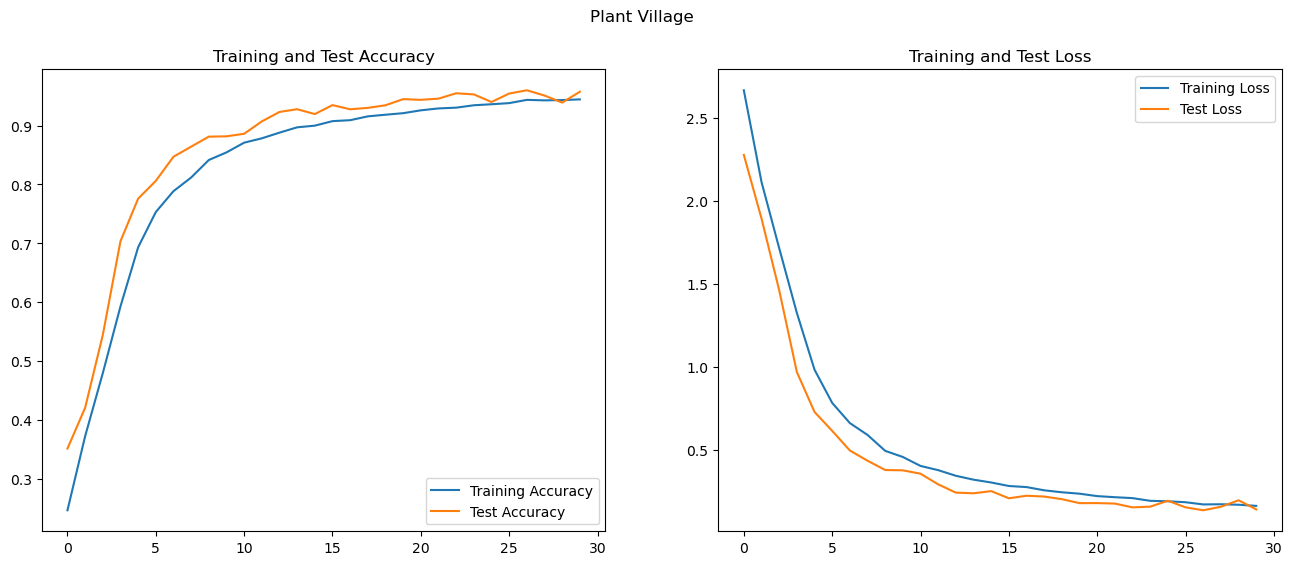

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Test Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Test Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Test Loss')

plt.suptitle('Plant Village')

plt.show()

In [1]:
from tqdm import tqdm
test_image_data = []
test_image_filenames = []

for directory in os.listdir(TEST_DIR):
    print(directory)
    class_path = os.path.join(TEST_DIR, directory)
    for img_name in tqdm(os.listdir(class_path)):
        img = load_img(os.path.join(class_path, img_name), target_size=IMG_SHAPE)
        test_image_data.append(img_to_array(img, dtype='uint8'))
        test_image_filenames.append(directory)
    
test_image_data = np.array(test_image_data) / 255
print(f'\nTotal testing images: {len(test_image_data)}')

NameError: name 'os' is not defined

In [ ]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)

In [160]:
import pandas as pd
test_pred_classes = [class_name_lookup[i] for i in test_pred]

predictions_df=pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })
predictions_df

Filename     Predicted classes
0      Strawberry___healthy      Potato___healthy
1      Strawberry___healthy  Strawberry___healthy
2      Strawberry___healthy  Strawberry___healthy
3      Strawberry___healthy      Tomato___healthy
4      Strawberry___healthy  Strawberry___healthy
...                     ...                   ...
10844     Soybean___healthy     Soybean___healthy
10845     Soybean___healthy     Soybean___healthy
10846     Soybean___healthy     Soybean___healthy
10847     Soybean___healthy     Soybean___healthy
10848     Soybean___healthy     Soybean___healthy

[10849 rows x 2 columns]

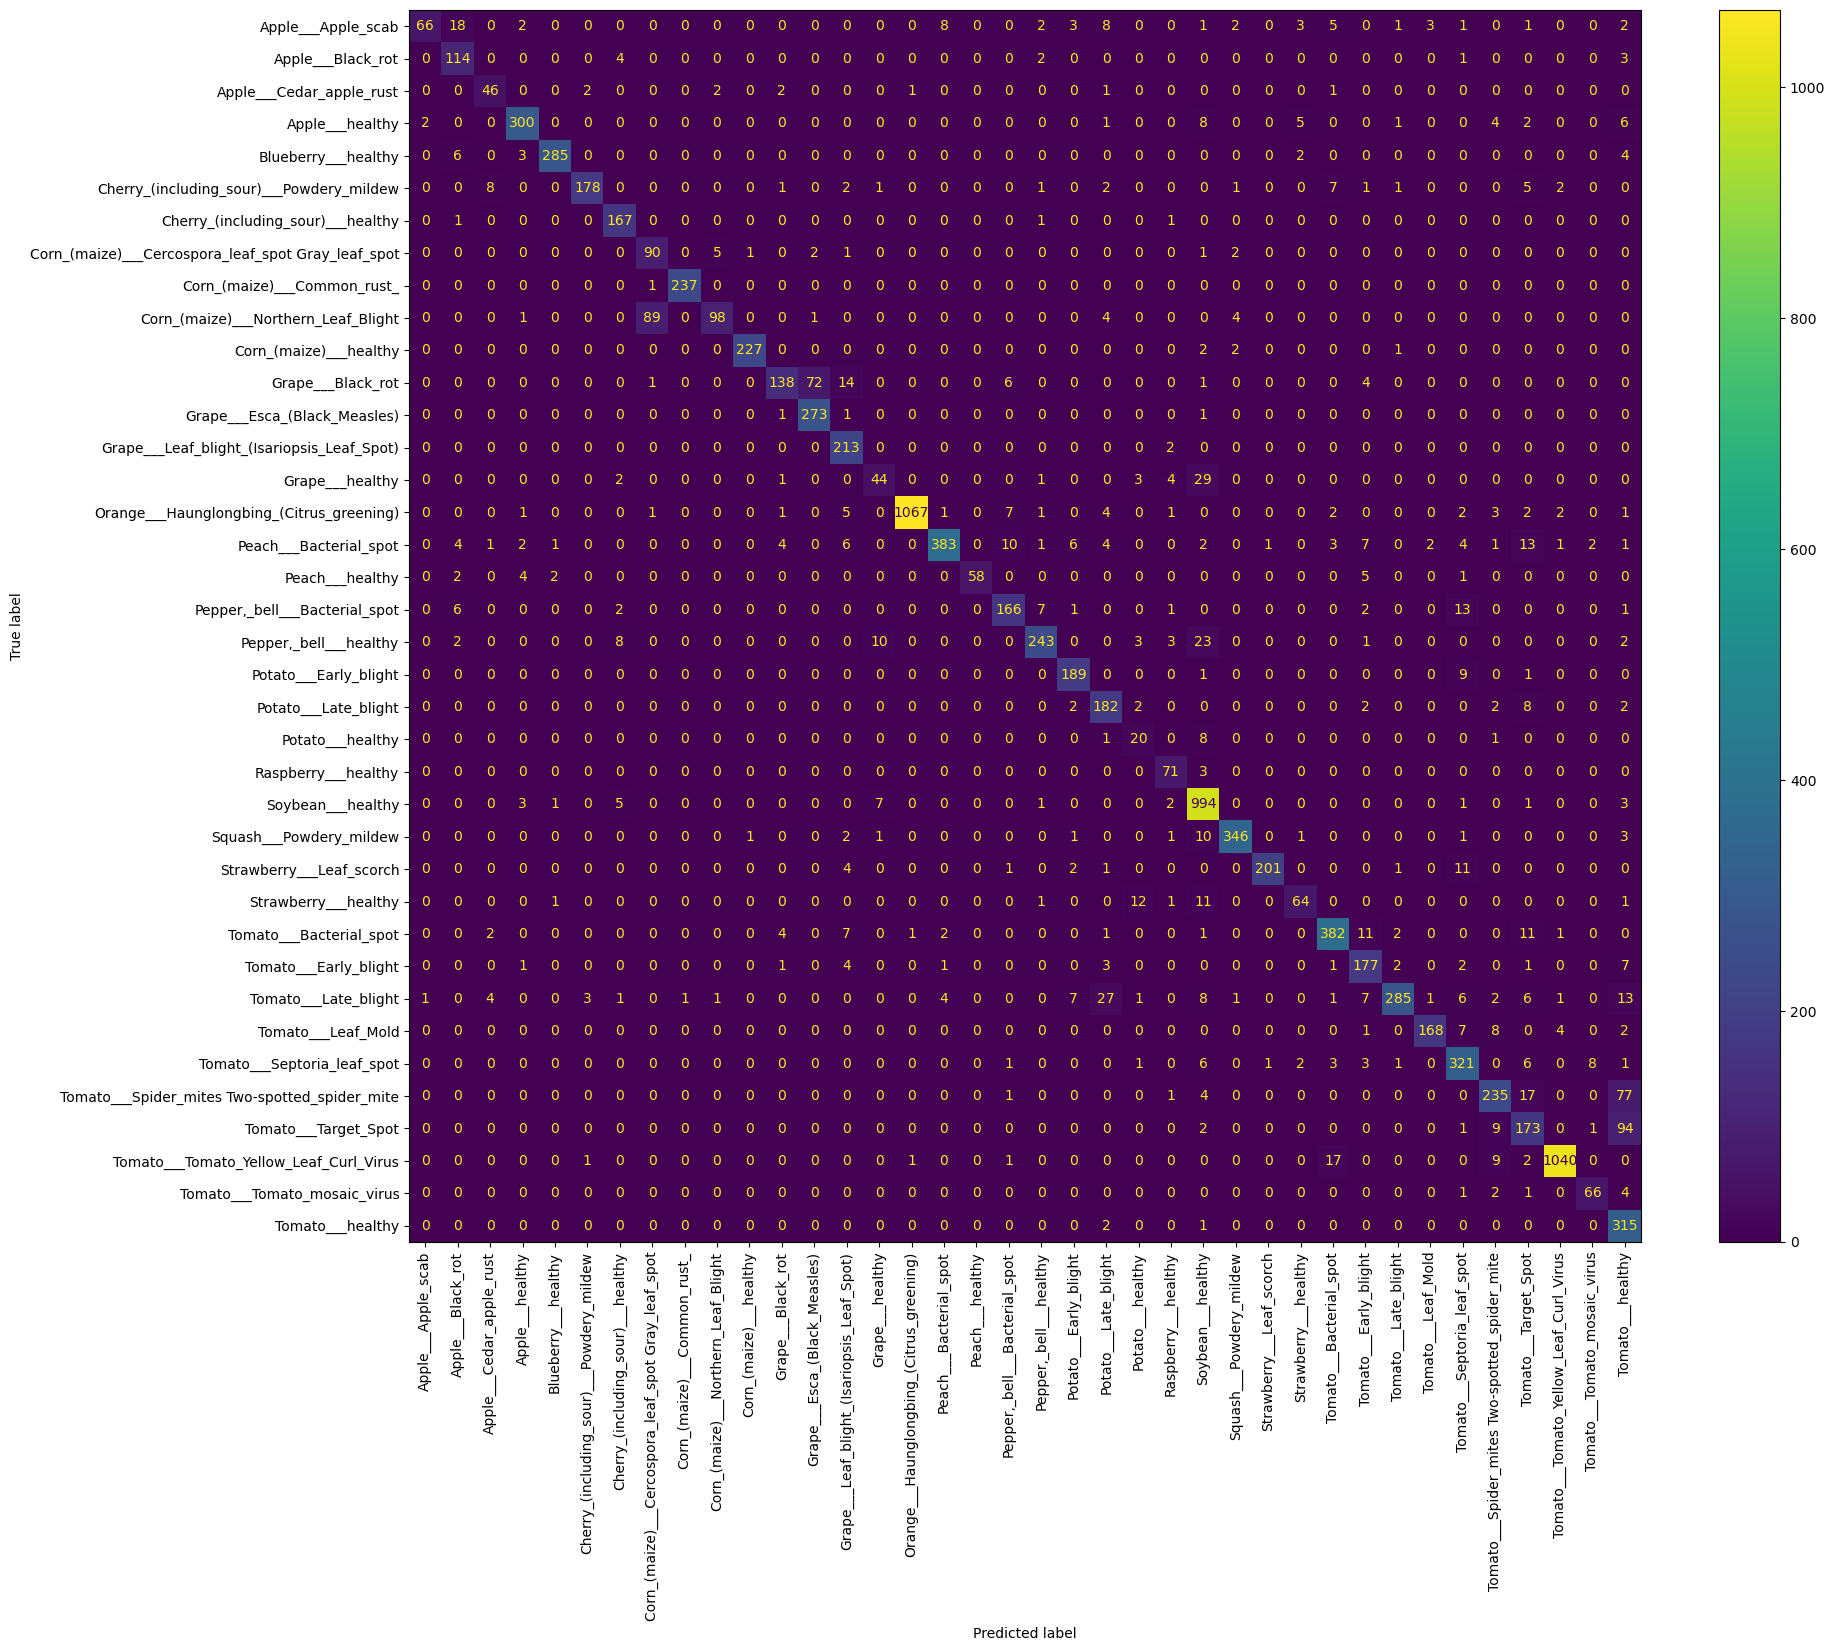

In [162]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(predictions_df['Filename'], predictions_df['Predicted classes'])

_, ax = plt.subplots(figsize=(20, 16))
ConfusionMatrixDisplay(conf_matrix,
                       display_labels=list(class_name_lookup.values())).plot(ax=ax, xticks_rotation='vertical')

plt.show()

In [163]:
total_images_per_class = conf_matrix.sum(axis=1)
correct_predictions_per_class = np.diag(conf_matrix)
percentage_correct_predictions = (correct_predictions_per_class / total_images_per_class) * 100

data = {
    'Classe': list(class_name_lookup.values()),
    'Pourcentage de valeurs correctement prédites': percentage_correct_predictions.round(2)
}

result_df = pd.DataFrame(data)
result_df

Classe  \
0                                  Apple___Apple_scab   
1                                   Apple___Black_rot   
2                            Apple___Cedar_apple_rust   
3                                     Apple___healthy   
4                                 Blueberry___healthy   
5            Cherry_(including_sour)___Powdery_mildew   
6                   Cherry_(including_sour)___healthy   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
8                         Corn_(maize)___Common_rust_   
9                 Corn_(maize)___Northern_Leaf_Blight   
10                             Corn_(maize)___healthy   
11                                  Grape___Black_rot   
12                       Grape___Esca_(Black_Measles)   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
14                                    Grape___healthy   
15           Orange___Haunglongbing_(Citrus_greening)   
16                             Peach___Bacterial_spot   
17                                    Peach___healthy   
18                      Pepper,_bell___Bacterial_spot   
19                             Pepper,_bell___healthy   
20                              Potato___Early_blight   
21                               Potato___Late_blight   
22                                   Potato___healthy   
23                                Raspberry___healthy   
24                                  Soybean___healthy   
25                            Squash___Powdery_mildew   
26                           Strawberry___Leaf_scorch   
27                               Strawberry___healthy   
28                            Tomato___Bacterial_spot   
29                              Tomato___Early_blight   
30                               Tomato___Late_blight   
31                                 Tomato___Leaf_Mold   
32                        Tomato___Septoria_leaf_spot   
33      Tomato___Spider_mites Two-spotted_spider_mite   
34                               Tomato___Target_Spot   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
36                       Tomato___Tomato_mosaic_virus   
37                                   Tomato___healthy   

    Pourcentage de valeurs correctement prédites  
0                                          52.38  
1                                          91.94  
2                                          83.64  
3                                          91.19  
4                                          95.00  
5                                          84.76  
6                                          98.24  
7                                          88.24  
8                                          99.58  
9                                          49.75  
10                                         97.84  
11                                         58.47  
12                                         98.91  
13                                         99.07  
14                                         52.38  
15                                         96.91  
16                                         83.44  
17                                         80.56  
18                                         83.42  
19                                         82.37  
20                                         94.50  
21                                         91.00  
22                                         66.67  
23                                         95.95  
24                                         97.64  
25                                         94.28  
26                                         90.95  
27                                         70.33  
28                                         89.88  
29                                         88.50  
30                                         74.80  
31                                         88.42  
32                                         90.68  
33                                         70.15  
34                                    

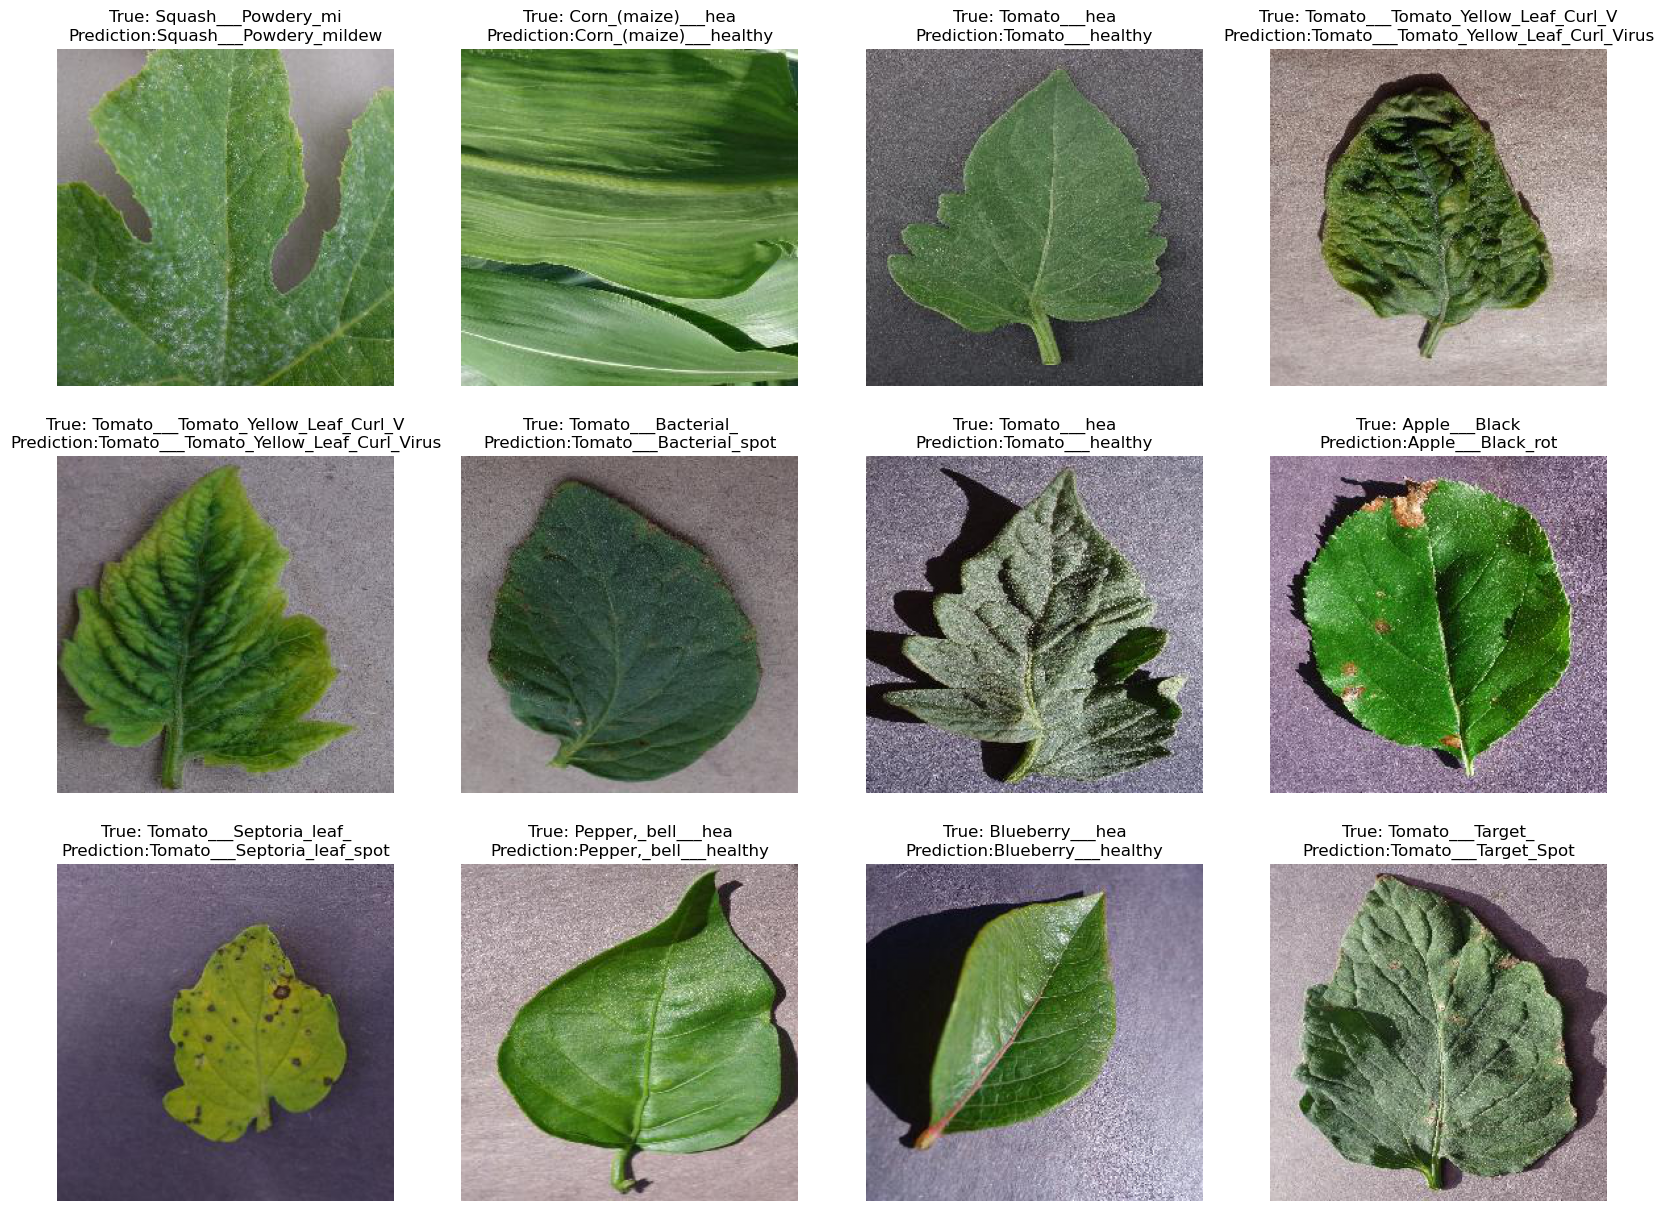

In [164]:

shuffled_indices = list(range(len(test_image_data)))
random.shuffle(shuffled_indices)

plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for i in range(12):
    idx = shuffled_indices[i] 
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[idx])
    plt.title(f"True: {test_image_filenames[idx][:-4]}\nPrediction:{test_pred_classes[idx]}")

plt.show()

In [165]:
evaluation_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 43456 images belonging to 38 classes.


2023-12-17 19:06:48.171228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


679/679 [==============================] - 642s 944ms/step


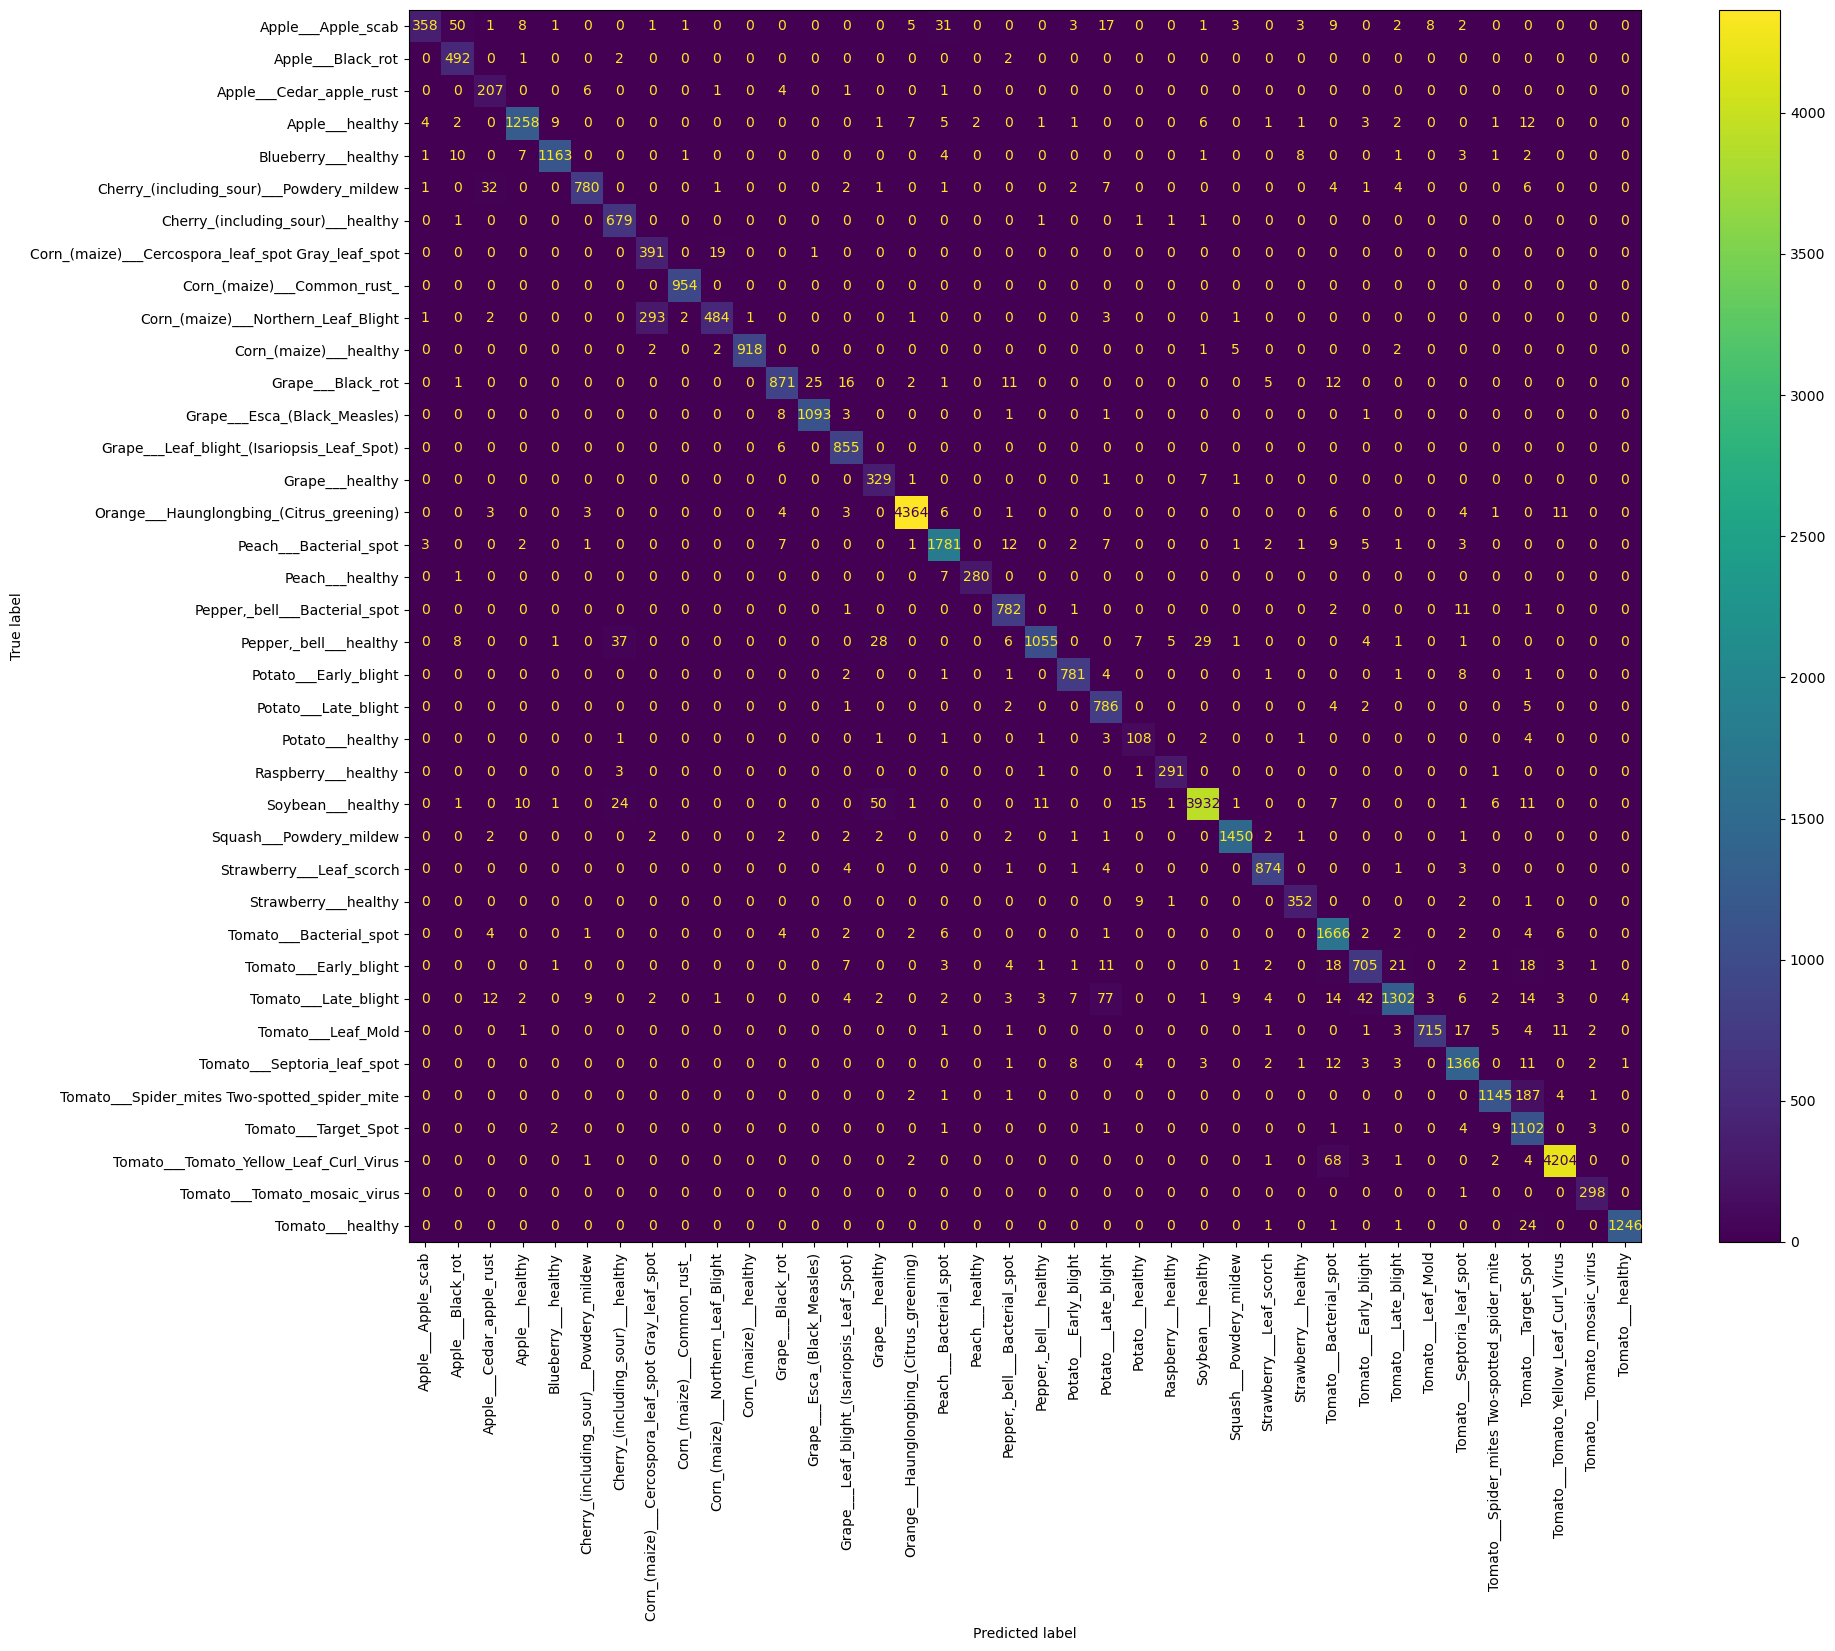

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_true = evaluation_data_gen.classes
train_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(train_true, train_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.show()

In [167]:
conf_matrix = confusion_matrix(train_true, train_pred)
total_images_per_class = conf_matrix.sum(axis=1)
correct_predictions_per_class = np.diag(conf_matrix)
percentage_correct_predictions = (correct_predictions_per_class / total_images_per_class) * 100

data = {
    'Classe': list(class_name_lookup.values()),
    'Pourcentage de valeurs correctement prédites': percentage_correct_predictions.round(2)
}

df = pd.DataFrame(data)
df


Classe  \
0                                  Apple___Apple_scab   
1                                   Apple___Black_rot   
2                            Apple___Cedar_apple_rust   
3                                     Apple___healthy   
4                                 Blueberry___healthy   
5            Cherry_(including_sour)___Powdery_mildew   
6                   Cherry_(including_sour)___healthy   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
8                         Corn_(maize)___Common_rust_   
9                 Corn_(maize)___Northern_Leaf_Blight   
10                             Corn_(maize)___healthy   
11                                  Grape___Black_rot   
12                       Grape___Esca_(Black_Measles)   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
14                                    Grape___healthy   
15           Orange___Haunglongbing_(Citrus_greening)   
16                             Peach___Bacterial_spot   
17                                    Peach___healthy   
18                      Pepper,_bell___Bacterial_spot   
19                             Pepper,_bell___healthy   
20                              Potato___Early_blight   
21                               Potato___Late_blight   
22                                   Potato___healthy   
23                                Raspberry___healthy   
24                                  Soybean___healthy   
25                            Squash___Powdery_mildew   
26                           Strawberry___Leaf_scorch   
27                               Strawberry___healthy   
28                            Tomato___Bacterial_spot   
29                              Tomato___Early_blight   
30                               Tomato___Late_blight   
31                                 Tomato___Leaf_Mold   
32                        Tomato___Septoria_leaf_spot   
33      Tomato___Spider_mites Two-spotted_spider_mite   
34                               Tomato___Target_Spot   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
36                       Tomato___Tomato_mosaic_virus   
37                                   Tomato___healthy   

    Pourcentage de valeurs correctement prédites  
0                                          71.03  
1                                          98.99  
2                                          94.09  
3                                          95.59  
4                                          96.76  
5                                          92.64  
6                                          99.27  
7                                          95.13  
8                                         100.00  
9                                          61.42  
10                                         98.71  
11                                         92.27  
12                                         98.74  
13                                         99.30  
14                                         97.05  
15                                         99.05  
16                                         96.90  
17                                         97.22  
18                                         97.99  
19                                         89.18  
20                                         97.62  
21                                         98.25  
22                                         88.52  
23                                         97.98  
24                                         96.56  
25                                         98.77  
26                                         98.42  
27                                         96.44  
28                                         97.88  
29                                         88.12  
30                                         85.21  
31                                         93.83  
32                                         96.40  
33                                         85.38  
34                                    

In [168]:
from sklearn.metrics import classification_report
class_report = classification_report(predictions_df['Filename'], predictions_df['Predicted classes'])
print(class_report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.52      0.68       126
                                 Apple___Black_rot       0.75      0.92      0.82       124
                          Apple___Cedar_apple_rust       0.75      0.84      0.79        55
                                   Apple___healthy       0.95      0.91      0.93       329
                               Blueberry___healthy       0.98      0.95      0.97       300
          Cherry_(including_sour)___Powdery_mildew       0.97      0.85      0.90       210
                 Cherry_(including_sour)___healthy       0.88      0.98      0.93       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.49      0.88      0.63       102
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.92      0.50      0.

In [1]:
from sklearn.metrics import classification_report
class_report = classification_report(predictions_df['Filename'], predictions_df['Predicted classes'])
print(class_report)

NameError: name 'predictions_df' is not defined